In [16]:
!pip install boruta


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Task 1: Data Loading and Initial Exploration

   pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.0000      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0                     St 

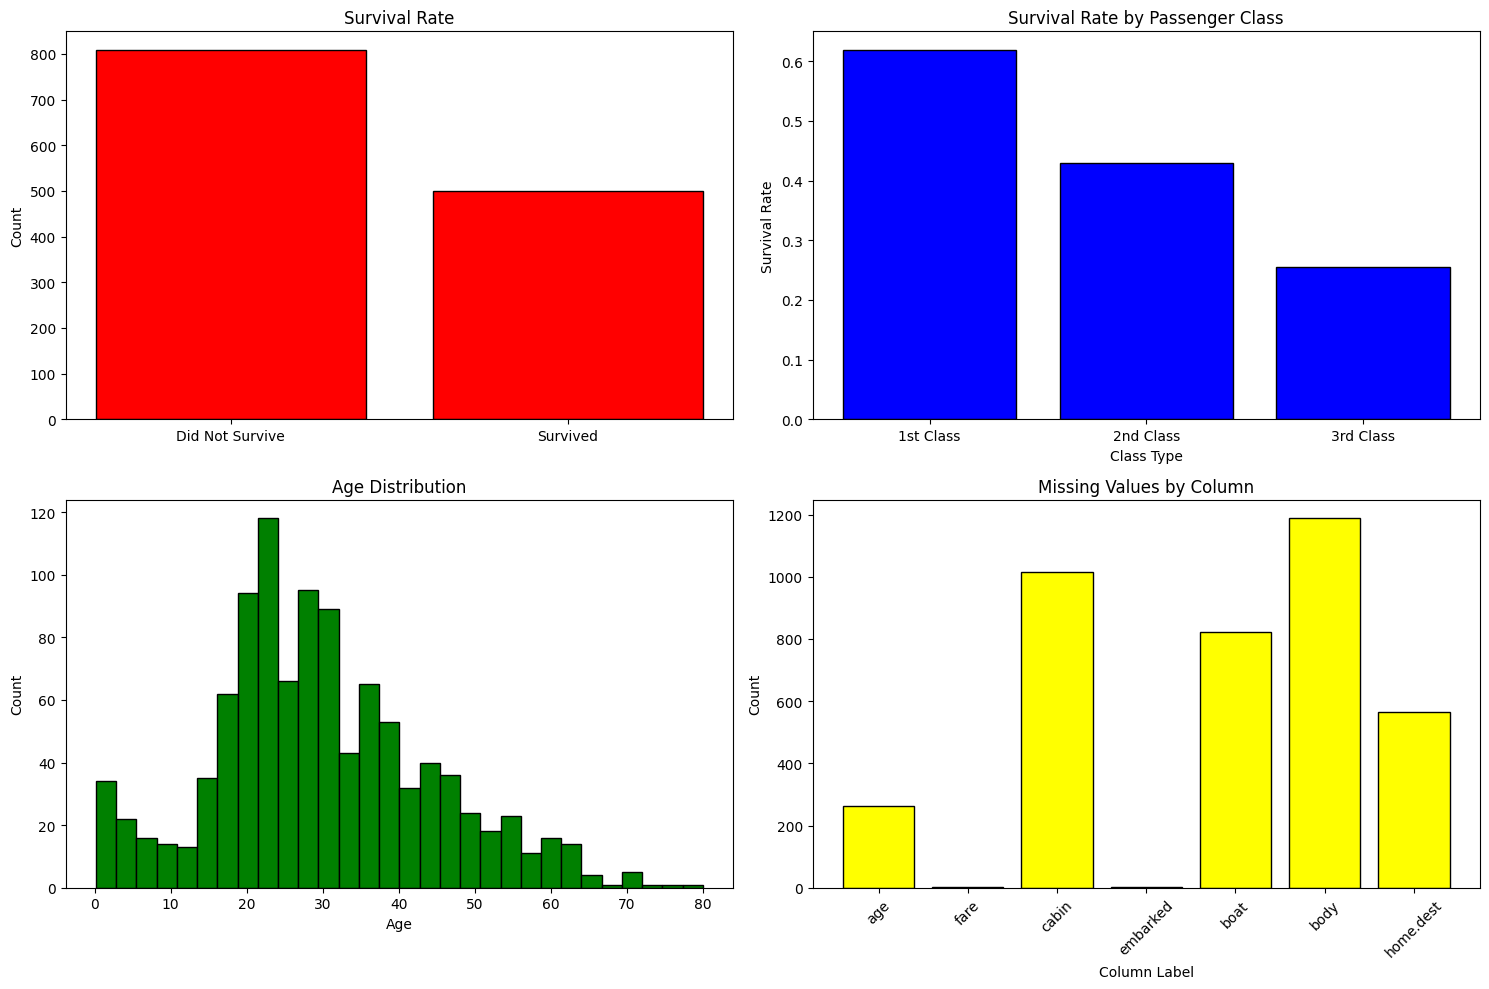

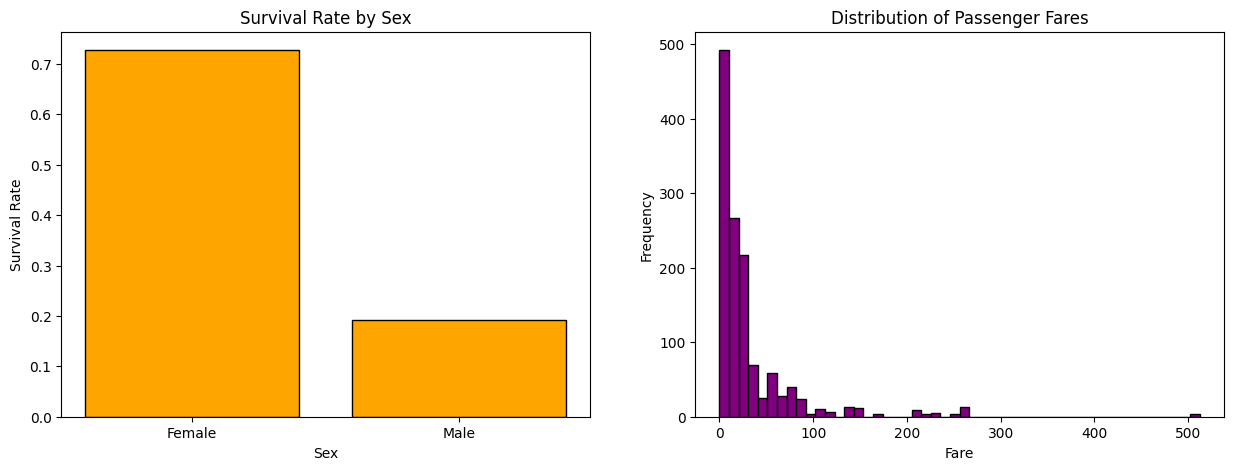

<Figure size 640x480 with 0 Axes>

In [120]:
import matplotlib.pyplot as plt
import numpy as np

# Loading dataset into a data frame
import pandas as pd
df = pd.read_excel(r'C:\Users\Omar Issa\Desktop\titanic3.xls')

# Displaying general information about the dataset
print(df.head())
print(df.info())

# Visualizing the dataset 
plt.figure(figsize=(15, 10))

# 1. Survival Distribution
plt.subplot(2, 2, 1)
survival_counts = df['survived'].value_counts()
plt.bar(['Did Not Survive', 'Survived'], [survival_counts[0], survival_counts[1]], color = 'red', edgecolor='black')
plt.title('Survival Rate')
plt.ylabel('Count')

# 2. Survival by Passenger Class
plt.subplot(2, 2, 2)
survival_by_class = df.groupby('pclass')['survived'].mean()
plt.bar(['1st Class', '2nd Class', '3rd Class'], survival_by_class, color = 'blue', edgecolor = 'black')
plt.title('Survival Rate by Passenger Class')
plt.ylabel('Survival Rate')
plt.xlabel('Class Type')

# 3. Age Distribution
plt.subplot(2, 2, 3)
plt.hist(df['age'].dropna(), bins=30, color = 'green', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

# 4. Missing Values
plt.subplot(2, 2, 4)
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
plt.bar(range(len(missing_values)), missing_values.values, color = 'yellow', edgecolor='black')
plt.xticks(range(len(missing_values)), missing_values.index, rotation=45)
plt.title('Missing Values by Column')
plt.ylabel('Count')
plt.xlabel('Column Label')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))

# 5. Survival by Sex

plt.subplot(1, 2, 1)
survival_by_sex = df.groupby('sex')['survived'].mean()
plt.bar(['Female', 'Male'], survival_by_sex, color = 'orange', edgecolor='black')
plt.title('Survival Rate by Sex')
plt.ylabel('Survival Rate')
plt.xlabel('Sex')


# 6. Fares Distribution
plt.subplot(1, 2, 2)
plt.hist(df['fare'], bins=50, color = 'purple', edgecolor='black')
plt.title('Distribution of Passenger Fares')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show()

plt.tight_layout()
plt.show()


## *Task One Remarks:* 

### Reasoning behind plots:

1) Plot 1: Survival rate bar chart was used for me to understand who survived and who didn't.
2) Plot 2: Passenger class survival rate could see the difference in survival rates per class, potentially indicating useful correlations.
3) Plot 3: Age distribution histogram allowed me to see the distribution of ages across the passengers of the titanic. This could aid in identifying any potential outliers and unusual trends in the distribution. This is important later when cleaning the data.
4) Plot 4: Missing values is important so I can gain insight into which columns need their data cleaned.
5) Plot 5: The sex survival rate plot is important to show the disparity in how females vs males survived, as historically females were allowed to board
  the rescue boats before men.
6) Plot 6: Fares distribution, similair to plot three, could help identify if there are outliers that need to be taken into account when cleaning the fares data.



## Task 2: Managing Missing Values

In [98]:
# Creating a copy of the data frame to avoid any issues
df_clean = df.copy()

# 1. Handle 'age':
# Strategy: Fill missing age values with median age
median_age = df_clean['age'].median()
df_clean['age'] = df_clean['age'].fillna(median_age)

# 2. Handle 'cabin':
# Strategy: Create deck feature from first letter, then drop cabin
df_clean['deck'] = df_clean['cabin'].str[0]
df_clean['deck'] = df_clean['deck'].fillna('Unknown')

# 3. Handle 'fare':
# Strategy: Fill the missing value with the median
median_fares = df_clean.groupby('pclass')['fare'].median()
for pclass, median_fare in median_fares.items():
    mask = df_clean['pclass'] == pclass
    df_clean.loc[mask, 'fare'] = df_clean.loc[mask, 'fare'].fillna(median_fare)

# 4. Handling 'name':
# Strategy: Extract the title of the individuals and then drop the names.
df_clean['title'] = df_clean['name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

# Standardizing titles
title_mapping = {
    'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
    'Lady': 'Mrs', 'Countess': 'Mrs', 'Dona': 'Mrs',
    'Sir': 'Mr', 'Don': 'Mr', 'Jonkheer': 'Mr',
    'Capt': 'Officer', 'Col': 'Officer', 'Major': 'Officer',
    'Dr': 'Officer', 'Rev': 'Officer'
}
df_clean['title'] = df_clean['title'].map(title_mapping).fillna(df_clean['title'])

# Dropping columns that aren't needed for prediction
columns_drop = ['ticket', 'cabin', 'boat', 'body', 'home.dest','name', 'embarked']
df_clean = df_clean.drop(columns=columns_drop)

print("\nColumns dropped after Task 2:")
print(columns_drop)
print("\nFinal columns after Task 2:")
print(df_clean.columns.tolist())



Columns dropped after Task 2:
['ticket', 'cabin', 'boat', 'body', 'home.dest', 'name', 'embarked']

Final columns after Task 2:
['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare', 'deck', 'title']


## *Task 2 Remarks:*

### - Justification behind handling the missing values from the above features:
1. The *'age'* feature: The median is chosen because it is less sensitive to outliers compared to the mean. Age might have a skewed distribution, and filling missing values with the median ensures that we don't introduce bias or outliers in the dataset.
2.  The *'fare'* feature: Due to the presence of different passenger classes on the titanic, fares can vary heavily between the passengers, making a mean unsuitable. The median is used again because it is robust to outliers. However, instead of filling all missing fares with the same median, I grouped by 'pclass' (since fares might differ between classes) and apply the class-specific median. This ensures that the missing values are replaced with more contextually relevant values based on passenger class.

### - Justification behind creating new features from exisiting features:
1. The *'deck'* feature from *'cabin'*: The most important part of the cabin feature was it's deck location. Different decks were assigned to different floors on the titanic, thus impacting the survival rate of the passengers. The accompanying information adjacent to the deck level held no significant value in my opinion on the survivability of the passenger. Hence, I extracted only the deck level of the passenger from the 'cabin' feature as I found it the most important. I also filled in any missing values in the 'deck' feature with "Unknown" to indicate that the deck is unknown for those rows.
2. The *'title'* feature from *'name'*: I determined that the name of the individual holds no value in determining if said individual will survive or not. However, the title preceeding the individual's name can indicate potentially their class, wealth, their sex, and their maritial status (Mrs. vs Miss for example). This could help in predicting if the person will survive or not. Thus, to reduce complexity of the data, only the titles were extracted and standardized from the 'name' column.

### - Justification behind dropping features:
- There were a few reasons behind dropping a few features from the original dataset. The first reason was that a new feature column was extracted from the original feature, thus was dropped as all relevant information from the original feature was extracted, such 'name' and 'cabin'. The second reason was that the features were found to have no important data that could aid in the predicition model and were then dropped.    




## Task 3: Encoding Categorical Variables

In [125]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

# Categorical features identified after task 2
categorical_features = ['pclass', 'sex', 'deck', 'title']

# Create the encoder
encoder = OneHotEncoder(drop='first', sparse_output=False) # Drop first was used to prevent issues with multicollinearity
encoded_features = encoder.fit_transform(df_clean[categorical_features])

# Get feature names for encoded columns
feature_names = []
for i, feature in enumerate(categorical_features):
   categories = encoder.categories_[i][1:]  
   feature_names.extend([f"{feature}_{cat}" for cat in categories])

# Creating a DataFrame with encoded features
encoded_df = pd.DataFrame(encoded_features, columns=feature_names,index=df_clean.index)

print("\nColumns after encoding:")
print(encoded_df.columns.tolist())
print("\nEncoded columns:")
print(encoded_df)

df_encoded = pd.concat([df_clean.drop(columns=categorical_features), encoded_df], axis=1)


Columns after encoding:
['pclass_2', 'pclass_3', 'sex_male', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'deck_T', 'deck_Unknown', 'title_Miss', 'title_Mr', 'title_Mrs', 'title_Officer']

Encoded columns:
      pclass_2  pclass_3  sex_male  deck_B  deck_C  deck_D  deck_E  deck_F  \
0          0.0       0.0       0.0     1.0     0.0     0.0     0.0     0.0   
1          0.0       0.0       1.0     0.0     1.0     0.0     0.0     0.0   
2          0.0       0.0       0.0     0.0     1.0     0.0     0.0     0.0   
3          0.0       0.0       1.0     0.0     1.0     0.0     0.0     0.0   
4          0.0       0.0       0.0     0.0     1.0     0.0     0.0     0.0   
...        ...       ...       ...     ...     ...     ...     ...     ...   
1304       0.0       1.0       0.0     0.0     0.0     0.0     0.0     0.0   
1305       0.0       1.0       0.0     0.0     0.0     0.0     0.0     0.0   
1306       0.0       1.0       1.0     0.0     0.0     0.0     0.0     0.0  

## *Task 3 Remarks*:

- The one-hot encoding transformation converts categorical variables (like sex and passenger class) into binary columns (0s and 1s), which is crucial for machine learning models that can only process numerical data.
- This transformation creates separate columns for each category while dropping one category per feature to avoid redundancy. For example, 'sex' becomes 'sex_male' (where 0 represents female and 1 represents male), and 'pclass' becomes 'pclass_2' and 'pclass_3' (with pclass_1 being dropped). This encoding ensures that the model doesn't assume any relationships between categories and can learn the true impact of each category on survival predictions independently.

## Task 4: Feature Scaling

In [123]:
from sklearn.preprocessing import StandardScaler

numerical_features = ['age', 'fare', 'parch', 'sibsp']

# Creating copies for different scaling methods
df_standard = df_encoded.copy()
df_minmax = df_encoded.copy()

# StandardScaler for standardization of numerical features (mean=0, std=1)
scaler_standard = StandardScaler()
df_standard[numerical_features] = scaler_standard.fit_transform(df_standard[numerical_features])

# MinMaxScaler for normalization of numerical features (scale to [0,1])
scaler_minmax = MinMaxScaler()
df_minmax[numerical_features] = scaler_minmax.fit_transform(df_minmax[numerical_features])

# Displaying Results
print("\nSample of StandardScaler results:")
print(df_standard[numerical_features].head())
print("\nSample of MinMaxScaler results:")
print(df_minmax[numerical_features].head())


Sample of StandardScaler results:
        age      fare     parch     sibsp
0 -0.039005  3.442540 -0.445000 -0.479087
1 -2.215952  2.286641  1.866526  0.481288
2 -2.131977  2.286641  1.866526  0.481288
3  0.038512  2.286641  1.866526  0.481288
4 -0.349075  2.286641  1.866526  0.481288

Sample of MinMaxScaler results:
        age      fare     parch  sibsp
0  0.361169  0.412503  0.000000  0.000
1  0.009395  0.295806  0.222222  0.125
2  0.022964  0.295806  0.222222  0.125
3  0.373695  0.295806  0.222222  0.125
4  0.311064  0.295806  0.222222  0.125


## *Task 4 Remarks:*

### - Difference between standardization (StandardScaler) and normalization (MinMaxScaler) methods:

- *Standardization* follows the formula  z = (x - μ) / σ, where the mean = 0 and standard deviation = 1. Standardization causes the data to be normally distributed. This method handles outliers better and has no bounded range, allowing for the use of algorithms with this method.
- *Normalization* follows the formula z = (x - min) / (max - min), where the range is between [0,1]. The data for normalization is not normally distributed. It also has a bounded range, making it harder to use algorithms and regression models with this method.

### - Which method is better for this model:
- Standardization (StandardScaler) is better suited to handle this model. This is because the data features outliers in features like 'age' and 'fares' that need to be handled properly to improve the accuracy of the model. Also the properties discussed above for the standardization method allows me to use logistic regression model and obtain proper results from it. Thus, standardization method has been adopted for use in this assignment. 

## Task 5: Data Splitting

In [128]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separating features and target
X = df_encoded.drop('survived', axis=1) # 'survived' was dropped of course to prevent data leakage 
y = df_encoded['survived'] # Target      

# First split: training+validation (80%) and test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, 
    test_size=0.2,         # 20% for test
    stratify=y,
    random_state=42
)

# Second split: dividing remaining 80% into training (60%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25,        # 25% of 80% = 20% total for validation
    stratify=y_train_val,
    random_state=42
)

# Scale after splitting
numerical_features = ['age', 'fare', 'parch', 'sibsp']
scaler = StandardScaler()

# Fitting and transforming on training data only
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])

# Transforming validation and test using fitted scaler
X_val[numerical_features] = scaler.transform(X_val[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Verify distributions
print("Training distribution (60%):\n", y_train.value_counts(normalize=True))
print("Validation distribution (20%):\n", y_val.value_counts(normalize=True))
print("Test distribution (20%):\n", y_test.value_counts(normalize=True))

Training distribution (60%):
 survived
0    0.617834
1    0.382166
Name: proportion, dtype: float64
Validation distribution (20%):
 survived
0    0.618321
1    0.381679
Name: proportion, dtype: float64
Test distribution (20%):
 survived
0    0.618321
1    0.381679
Name: proportion, dtype: float64


## Task 5 Remarks:

### Explination and Justification of the data splitting process:

- The data followed the '60-20-20' split.
- The 60-20-20 split is when 60% of the data is allocated to training, ensuring sufficient data for the model to learn patterns and for SMOTE to create synthetic samples. The remaining 40% is evenly split between validation and test sets (approximately 262 samples each), where the validation set is used to tune model parameters and detect overfitting, while the test set provides an unbiased final evaluation of model performance.
- This split balances the need to train a large of data adequetly, while mainting a reasonable amount of data left for the validation and testing sets to provide a reliable model.
  

## Task 6: Addressing Class Imbalance

In [111]:
from imblearn.over_sampling import SMOTE

# Checking the imbalance
print("Imbalance in training data:")
print(y_train.value_counts())
print("\nTraining set shape before SMOTE:", X_train.shape) 

# Fixing the imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train) 

# Results after using SMOTE
print("\nTraining set shape after SMOTE:", X_resampled.shape)
print("\nClass distribution after SMOTE:")
print(y_resampled.value_counts())

Imbalance in training data:
survived
0    485
1    300
Name: count, dtype: int64

Training set shape before SMOTE: (785, 19)

Training set shape after SMOTE: (970, 19)

Class distribution after SMOTE:
survived
0    485
1    485
Name: count, dtype: int64


## Task 7: Feature Selection

Variances of features:
age: 1.0173
sibsp: 0.8683
parch: 0.9251
fare: 0.9852
pclass_2: 0.1809
pclass_3: 0.2499
sex_male: 0.2427
deck_B: 0.0550
deck_C: 0.0670
deck_D: 0.0371
deck_E: 0.0311
deck_F: 0.0160
deck_G: 0.0053
deck_T: 0.0000
deck_Unknown: 0.1826
title_Miss: 0.1744
title_Mr: 0.2495
title_Mrs: 0.1530
title_Officer: 0.0173

Features with variance > 0.01:
['age', 'sibsp', 'parch', 'fare', 'pclass_2', 'pclass_3', 'sex_male', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_Unknown', 'title_Miss', 'title_Mr', 'title_Mrs', 'title_Officer']

Shape before variance threshold: (970, 19)

Shape after variance threshold: (970, 17)


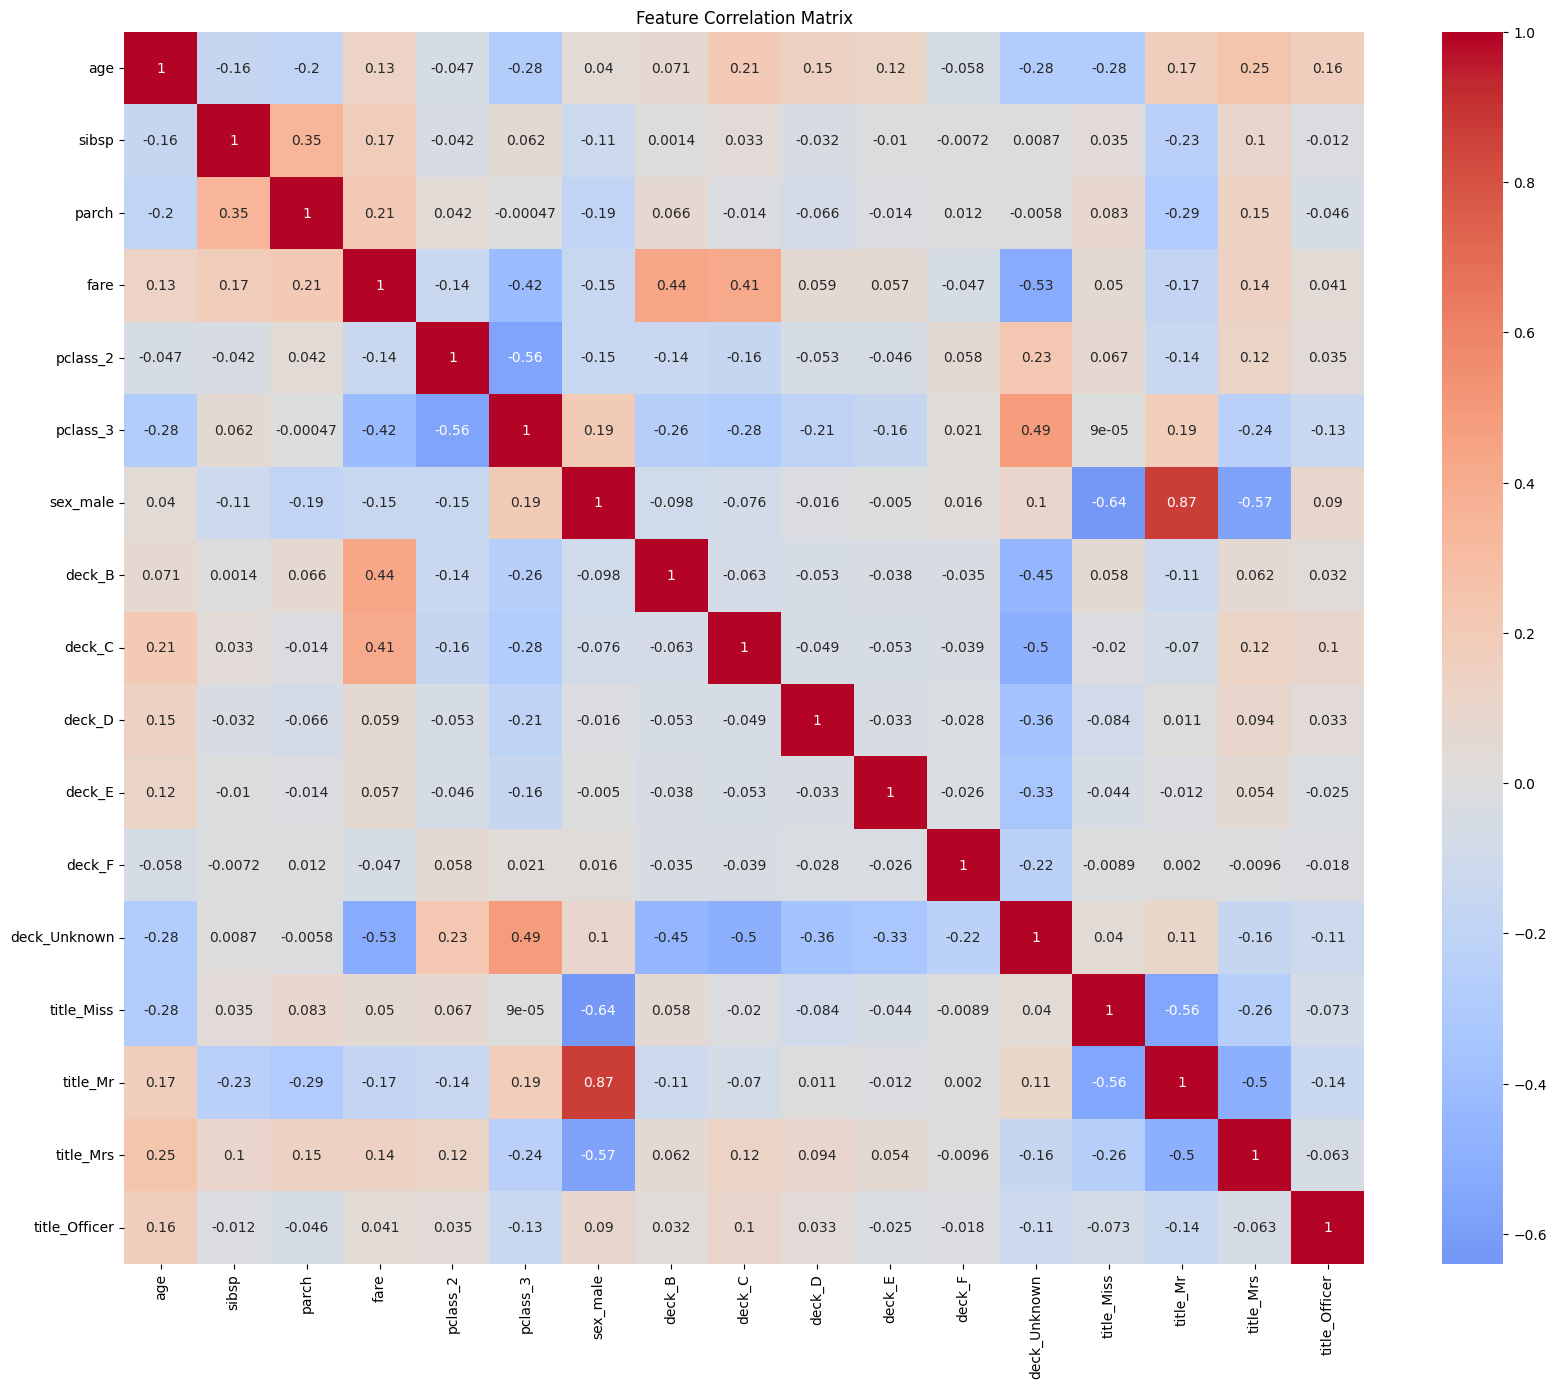

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	6
Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	6
Iteration: 	10 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	6
Iteration: 	11 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	6
Iteration: 	12 / 100
Confirmed: 	10
Tentative: 	0
Rejected: 	7


BorutaPy finished running.

Iteration: 	13 / 100
Confirmed: 	10
Tentative: 	0
Rejected: 	7

Features selected by Boruta:
['age', 'sibsp', 'parch', 'fare', 'pclass_3', 'sex_male', 'deck_Unknown', 'title_Miss', 'title_Mr', 'title_Mrs']

Feature Ranking:
   

In [112]:
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# First: Variance analysis
variances = X_resampled.var()
print("Variances of features:")
for feature, variance in variances.items():
    print(f"{feature}: {variance:.4f}")

# Applying variance threshold
threshold = 0.01
selector = VarianceThreshold(threshold)
X_selected = selector.fit_transform(X_resampled)

# Display results after low variance features were dropped
selected_features = X_resampled.columns[selector.get_support()].tolist()
print("\nFeatures with variance > 0.01:")
print(selected_features)
print("\nShape before variance threshold:", X_resampled.shape)
print("\nShape after variance threshold:", X_selected.shape)

# Second: Correlation analysis
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)
corr = X_selected_df.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr, annot = True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# Third: Boruta Feature Selection
rf = RandomForestClassifier(n_jobs=-1, max_depth=5)
boruta = BorutaPy(rf, n_estimators='auto', verbose=2)
boruta.fit(X_selected, y_resampled)

# Getting selected feature names
selected_by_boruta = [selected_features[i] for i in range(len(selected_features)) if boruta.support_[i]]

print("\nFeatures selected by Boruta:")
print(selected_by_boruta)

# Showing ranking of features
feature_ranks = pd.DataFrame({'Feature': selected_features,'Rank': boruta.ranking_,'Important': boruta.support_})
print("\nFeature Ranking:")
print(feature_ranks.sort_values('Rank'))

X_selected_df = X_selected_df.drop('title_Mr', axis=1)
print("\nShape after dropping title_Mr:", X_selected_df.shape)


## *Task Seven Remarks*:

### 1) Variance analysis: 

- A low variance threshold was set at (0.01) which is what I found online is commonly used to determine low variance.

- 'deck_t' and 'deck_g' were removed for being below the variance threshold.

### 2) Correlation Matrix and Boruta algorithm analysis:

- The correlation matrix indicated generally a low correlation between multiple variables, this shows that most variables are independent.
- Boruta algorithm identified 10 key features which capture diverse aspects of passenger characteristics.
- The model indicates only one really strong correlation between the 'title_Mr'  and 'sex_male' at (0.87). This is expected, as the title 'Mr.' is used to indicate to a man. Hence, based on the boruta analysis and correlation matrix, to avoid redudancy of the data the 'title_Mr' was dropped.



## Task 8: Training a Logistic Regression Model

Overall Accuracy: 0.7729
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       324
           1       0.69      0.73      0.71       200

    accuracy                           0.77       524
   macro avg       0.76      0.76      0.76       524
weighted avg       0.78      0.77      0.77       524



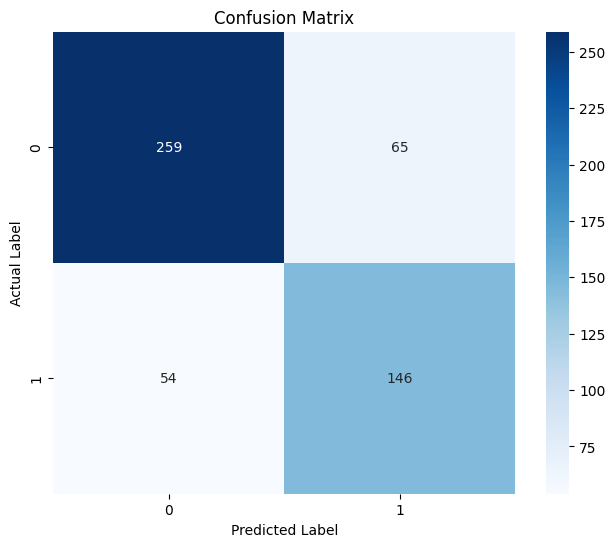

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Preparing data set after task seven results
X_val_selected = selector.transform(X_val)
X_val_df = pd.DataFrame(X_val_selected, columns=selected_features)
X_val_df = X_val_df.drop('title_Mr', axis=1)

# Training model
lr_model = LogisticRegression(random_state=8, max_iter=1000)
lr_model.fit(X_selected_df, y_resampled)
y_pred = lr_model.predict(X_val_df)

# Results
accuracy = accuracy_score(y_val, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_val, y_pred, zero_division=1))

# Displaying confusion matrix results on a seaborn plot to make it more visually appealing
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True,fmt='d', cmap='Blues', square=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()